In [1]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import os

# os.chdir("..")

In [2]:
import wandb

class WandbRunNames(dict):
    def __init__(self):
        self.api = wandb.Api()
        self['cwvae'] = 'cwvae'
        
    def __getitem__(self, id):
        if id in self:
            return super().__getitem__(id)
        else:
            name = self.api.run(f"universal-conditional-ddpm/video-diffusion/{id}").name
            self[id] = name
            return name

run_names = WandbRunNames()

nice_mode_names = {
    'autoreg': 'Autoregressive',
    'adaptive-autoreg': 'Adaptive autoregressive',
    'independent': 'Only original observations',
    'mixed-autoreg-independent': 'Mixed',
    'hierarchy-2': 'Hierarchy-2',
    'hierarchy-3': 'Hierarchy-3',
    'hierarchy-4': 'Hierarchy-4',
    'hierarchy-5': 'Hierarchy-5',
    'really-independent': 'Independent',
    'cwvae': 'CWVAE',
}

def pad_to_len(s, l):
    return s + ' '*max(0, l-len(s))

def directory(path):
    return path if path.is_dir() else path.parent

class ExpInfo:
    def __init__(self):
        pass
    
class ExpDB:
    globber = "**/new_metrics_*.pkl"
    def __init__(self, data=[], dir_path=None):
        assert data == [] or dir_path is None
        if dir_path is not None:
            self.data = []
            for path in Path(dir_path).glob(self.globber):
                self.add_from_path(path)
        else:
            self.data = data
    
    def add_from_path(self, path):
        name = path.stem
        mode, max_len, pred_size, T, obs_length = path.parent.name.split("_")
        test_set_size, n_samples, T_pred = name.split("_")[-1].split("-")
        max_len, pred_size, test_set_size, n_samples, T_pred = map(int, [max_len, pred_size, test_set_size, n_samples, T_pred])
        config = dict(mode=mode, max_len=max_len, pred_size=pred_size,
                      test_set_size=test_set_size, n_samples=n_samples,
                      T_pred=T_pred, T=T, obs_length=obs_length)
        metrics = pickle.load(open(path, "rb"))
        self.data.append({"path": path,
                          "config": config,
                          "metrics": metrics})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __iter__(self):
        return iter(self.data)

    def query(self, **kwargs):
        return ExpDB([x for x in self.data if all([x["config"][k] == v for (k,v) in kwargs.items()])])

    def sort(self, keys):
        if isinstance(keys, str):
            self.sort([keys])
        self.data.sort(key=lambda x: [x["config"][k] for k in keys])
        
    def get_sorted(self, keys):
        if isinstance(keys, str):
            return self.get_sorted([keys])
        return ExpDB(data=sorted(self.data, key=lambda x: [x["config"][k] for k in keys]))
        
    def print_config(self):
        for x in self.data:
            print(x["config"])
            

class ElboDB(ExpDB):
    globber = "**/elbo_*.pkl"
    def __init__(self, data=[], dir_path=None):
        assert data == [] or dir_path is None
        if dir_path is not None:
            self.data = []
            for path in set(path.parent for path in Path(dir_path).glob(self.globber)):
                self.add_from_path(path)
        else:
            self.data = data

    def add_from_path(self, path):
        i = 0
        data = None
        while os.path.exists(path / f"elbo_{i}.pkl"):
            data_i = pickle.load(open(path / f"elbo_{i}.pkl", 'rb'))
            if i == 0:
                data = {k: [] for k in data_i}
            for k in data:
                data[k].append(data_i[k])
            i += 1
        data = {k: np.stack(v, axis=0) for k, v in data.items()}
        self.data.append({"path": path,
                          "config": None,
                          "metrics": data})

# databases with FVDs/LPIPS
metrics_db = ExpDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/second-batch-400k-iters/')
inf_modes_db = [run for run in metrics_db if '3kdr4q5k' in str(run['path'])]
ablations_db = [run for run in metrics_db if 'hierarchy-2' in str(run['path'])]

## Test NLLs for varying max_frames

In [3]:
T160_db = ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/T160-200k-iters/')

def first_n(array, n):
    assert len(array) >= n
    return array[:n]

def max_frames_label_func(path):
    path = Path(directory(path))
    modes = {
        '12b3f0tz': ('Mazes', 'full video'),
        '3d4unb1k': ('Mazes', 'ours'),
        '34crrvr8': ('MineRL', 'full video'),
        '30v09jjq': ('MineRL', 'ours'),}
    sample_settings = path.parts[-1]
    sample_mode, max_frames, *_ = sample_settings.split('_')
    id = path.parts[-2]
    dataset, method = modes[id]
    label = f"{method} on {dataset}"
    if int(max_frames) == 160:
        label += " (generated at once)"
    else:
        label = label + f" (with {sample_mode}, max {max_frames} frames)"
    return label

to_show = {}
for run in T160_db:
    elbo = first_n(run['metrics']['total_bpd'], 100).sum(axis=1).mean(axis=0)
    label = max_frames_label_func(run['path'])
    to_show[label] = elbo

def print_things(dataset):
    for k, v in sorted(to_show.items(), key=lambda x: x[1]):
        if dataset in k:
            print(f"{v:.2f} - {k}")
            
print_things('MineRL')
print()
print_things('Mazes')

340.13 - ours on MineRL (with hierarchy-2, max 80 frames)
341.24 - ours on MineRL (with hierarchy-2, max 40 frames)
343.52 - ours on MineRL (with hierarchy-2, max 20 frames)
543.53 - ours on MineRL (generated at once)
543.64 - full video on MineRL (generated at once)

337.85 - ours on Mazes (with hierarchy-2, max 80 frames)
338.98 - ours on Mazes (with hierarchy-2, max 40 frames)
341.23 - ours on Mazes (with hierarchy-2, max 20 frames)
539.39 - ours on Mazes (generated at once)
539.57 - full video on Mazes (generated at once)


## Test FVDs for varying max_frames

In [4]:
T160_sample_db = ExpDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/T160-200k-iters/')

# TODO compute FVDs and LPIPs scores for this
fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in T160_sample_db if 'fvd' in run['metrics']]
fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
for fvd, run in fvds_runs:
    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
    id = run['path'].parts[-3]
    
    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(max_frames_label_func(run['path']), 40)}")

1104.28 +- 6.9 (3 seeds) - ours on Mazes (with hierarchy-2, max 20 frames)
1110.86 +- 6.9 (3 seeds) - ours on Mazes (generated at once)       
1120.50 +- 13.0 (3 seeds) - ours on Mazes (with hierarchy-2, max 80 frames)
1125.51 +- 2.8 (3 seeds) - ours on Mazes (with hierarchy-2, max 40 frames)
1230.05 +- 9.2 (3 seeds) - full video on Mazes (generated at once) 
1995.82 +- 9.3 (3 seeds) - ours on MineRL (with hierarchy-2, max 20 frames)


## Test NLLs for some ablations (all trained for 400k iterations on Mazes with T=300 and computed on masks sampled from our training distribution)

In [5]:
main_db = ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/second-batch-400k-iters/')

def ablation_label_func(path):
    modes = {
        '3kdr4q5k': 'Ours',
        '3kd38zvf': 'No padding with random frames',
        '8aj6rgym': 'With global frame encoding',
        }
    id = directory(path).parts[-2]
    return modes[id]

ablations = [run for run in main_db if 'differently-spaced-groups' in str(run['path'])]
for run in ablations:
    elbo = first_n(run['metrics']['total_bpd'], 100).sum(axis=1).mean(axis=0)
    print(f"{elbo:.2f} - {ablation_label_func(run['path'])}")

26.02 - With global frame encoding
26.00 - Ours
26.05 - No padding with random frames


## And FVDs for the same ablations

In [6]:
fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in ablations_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
for fvd, run in fvds_runs:
    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
    id = run['path'].parts[-3]
    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(ablation_label_func(run['path']), 30)} Trained with {run_names[id]}")

53.05 +- 1.5 (3 seeds) - No padding with random frames  Trained with ablation without random frame padding
58.92 +- 7.3 (3 seeds) - Ours                           Trained with proper mazes
59.02 +- 1.4 (3 seeds) - With global frame encoding     Trained with ablation with global frame encoding


# Stuff for RPE net ablation (https://wandb.ai/universal-conditional-ddpm/video-diffusion/sweeps/zrexk7n3)

## NLLs on training mask distribution

In [7]:
with_rpe_db =  ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/with-rpe-net-differently-spaced-groups/')
without_rpe_db =  ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/without-rpe-net-differently-spaced-groups/')


print('With RPE')
for run in with_rpe_db:
    if directory(run['path']).parts[-1].split('_')[0] == 'differently-spaced-groups':
        elbo = first_n(run['metrics']['total_bpd'], 32).sum(axis=1).mean(axis=0)
        print(elbo)

print('Without RPE')
for run in without_rpe_db:
    if directory(run['path']).parts[-1].split('_')[0] == 'differently-spaced-groups':
        elbo = first_n(run['metrics']['total_bpd'], 32).sum(axis=1).mean(axis=0)
        print(elbo)

With RPE
24.476505
24.482132
Without RPE
24.478382
24.487183
24.48713


## NLLS for pairs of far-apart frames

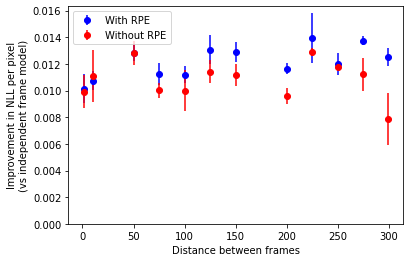

In [34]:
def get_spacing_i_db(original_db, i, independent):
    mask_name = f"linspace-no-obs-0-{i}-2"
    if independent:
        mask_name = 'independent-'+mask_name
    return [run for run in original_db if directory(run['path']).parts[-1].split('_')[0] == mask_name]

def plot(ax, x, runs, color, label, diff_to=None):
    values = np.array([first_n(run['metrics']['total_bpd'], 100).sum(axis=1).mean(axis=0) for run in runs])
    diff_to_values = np.array([first_n(run['metrics']['total_bpd'], 100).sum(axis=1).mean(axis=0) for run in diff_to])
    ax.errorbar(x, y=diff_to_values.mean()-values.mean(), yerr=values.std(), color=color, label=label, fmt='o')
    

fig, ax = plt.subplots()
xs = [1, 10, 50, 75, 100, 125, 150, 200, 225, 250, 275, 299]
for x in xs:
    with_runs = get_spacing_i_db(with_rpe_db, x, independent=False)
    without_runs = get_spacing_i_db(without_rpe_db, x, independent=False)
    independent_runs = get_spacing_i_db(without_rpe_db, x, independent=True)
    plot(ax, x, with_runs, color='b', label='With RPE' if x==xs[0] else None, diff_to=independent_runs)
    plot(ax, x, without_runs, color='r', label='Without RPE' if x==xs[0] else None, diff_to=independent_runs)
#     plot(ax, x, independent_runs, color='g', label='Independent' if x==xs[0] else None)

ax.set_xlabel('Distance between frames')
ax.set_ylabel('Improvement in NLL per pixel\n(vs independent frame model)')
ax.set_ylim(0)
fig.savefig('figs/rpe-net-effect-vs-distance.pdf', bbox_inches='tight')
ax.legend()

## Test NLLs for various different inference modes (all from same network trained for 400k iterations on Mazes with T=300)

In [9]:
inf_modes = [run for run in main_db if 'differently-spaced-groups' not in str(run['path'])]

def inf_mode_label_func(path):
    id = directory(path).parts[-2]
    assert id == '3kdr4q5k'
    return nice_mode_names[Path(directory(path)).parts[-1].split('_')[0]]



for metric in ['mse', 'total_bpd']:
    print('\nMetric:', metric)
    to_show = {}
    for run in inf_modes:
        metrics = run['metrics']
        path = run['path']
        try:
            elbo = first_n(metrics[metric], 100).sum(axis=1).mean(axis=0)  # TODO 100
        except:
            print('failed', path)
        to_show[f"{elbo:.2f} - {inf_mode_label_func(run['path'])}"] = elbo

    for label, elbo in sorted(to_show.items(), key=lambda x: x[1]):
        print(label)


Metric: mse
1759.94 - Mixed
1760.00 - Adaptive autoregressive
1761.13 - Autoregressive

Metric: total_bpd
701.35 - Mixed
701.38 - Adaptive autoregressive
701.44 - Autoregressive


## And test FVDs for the same runs

In [10]:
fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in inf_modes_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
for fvd, run in fvds_runs:
    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
    id = run['path'].parts[-3]
    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(inf_mode_label_func(run['path']), 40)}") #" Trained with {run_names[id]}")

58.61 +- 1.3 (3 seeds) - Hierarchy-3                             
58.92 +- 7.3 (3 seeds) - Hierarchy-2                             
59.36 +- 2.8 (3 seeds) - Hierarchy-4                             
62.39 +- 3.9 (3 seeds) - Mixed                                   
73.13 +- 3.9 (3 seeds) - Adaptive autoregressive                 
97.37 +- 2.9 (3 seeds) - Autoregressive                          
99.22 +- 2.2 (3 seeds) - Only original observations              
176.49 +- 2.7 (3 seeds) - Independent                             


In [24]:
_default_label_func = lambda x: f"{x['path'].parent.name}/{x['path'].stem}"


from scipy import stats
def smooth(x, std):
    # smooth a 1-D numpy array x
    gaussian_filter = stats.norm(0., 5.).pdf(np.arange(-5*std, 5*std))
    unnormed = np.convolve(x, gaussian_filter, 'same')
    norm_const = np.convolve(np.ones_like(x), gaussian_filter, 'same')
    return unnormed / norm_const


def do_plot(db, ax, mode, errorbar=True,
            label_func=_default_label_func,
            agg_mode="best",
            baseline_metrics=None, set_color=None,
            smooth_std=None, verbose=True):
    
    def agg_predictions(metric, agg_mode):
        assert agg_mode in ["best", "best_avg", "mean", "random"]
        best_fn = {"ssim": "max", "psnr": "max", "lpips": "min"}[mode]

        if agg_mode == "best":
            metric = getattr(metric[:, :2], best_fn)(axis=1)
        elif agg_mode == "best_avg":
            # Finding the order within samples wrt avg metric across time.
            order_metric = np.argsort(np.mean(metric, -1), axis=-1)
            assert best_fn in ["max", "min"]
            if best_fn == "max":
                metric = np.stack([metric[i, order[-1]] for (i, order) in enumerate(order_metric)])
            else:
                metric = np.stack([metric[i, order[0]] for (i, order) in enumerate(order_metric)])
        elif agg_mode == "random":
            metric = metric[:, 0, :]
        elif agg_mode == "mean":
            metric = metric.mean(axis=1)
        else:
            raise ValueError(f"Unknown aggregation mode {agg_mode}")
        return metric
    
    labels_seen = set()
    assert mode in ["ssim", "psnr", "lpips"]
    if label_func is None:
        label_func = lambda x: None
    for exp_data in db:
        path = str(exp_data["path"])
        metrics = exp_data["metrics"]
        if mode not in metrics:
            if verbose:
                print(f"Metrics {mode} not found in {path}")
            continue
        metric = agg_predictions(metrics[mode], agg_mode)

        mean = metric.mean(axis=0)
        if smooth_std is not None:
            mean = smooth(mean, smooth_std)
        std = metric.std(axis=0)
        label = None
        ls = '-'
        label = label_func(exp_data)
        
        color = set_color(path) if set_color is not None else None

        ax.plot(mean, label=None if label in labels_seen else label, color=color, ls=ls)
        labels_seen.add(label)
        if errorbar:
            ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1)
    ax.grid("on")

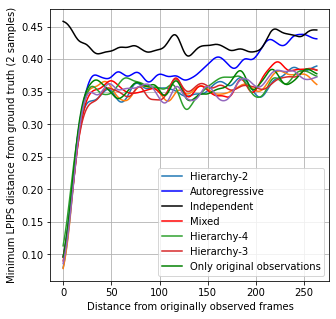

In [29]:
def set_color(path):
    if 'mixed' in path:
        return 'r'
    elif 'autoreg' in path:
        return 'b'
    elif 'really-independent' in path:
        return 'k'
    elif 'independent' in path:
        return 'g'
    elif 'cwvae' in path:
        return 'y'
def lpips_label_func(run):
    path = run['path']
    id = directory(path).parts[-2]
    return nice_mode_names[Path(directory(path)).parts[-1].split('_')[0]]
fig, ax = plt.subplots(figsize=(5, 5))
do_plot(metrics_db, ax, mode='lpips', errorbar=False, set_color=set_color,
       label_func=lpips_label_func, verbose=False, smooth_std=5)
ax.set_xlabel('Distance from originally observed frames')
ax.set_ylabel('Minimum LPIPS distance from ground truth (2 samples)')
ax.legend()

## FVD for various inference modes

In [13]:
#fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in inf_modes_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
#fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
#for fvd, run in fvds_runs:
#    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
#    id = run['path'].parts[-3]
#    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 40)} Trained with {run_names[id]}")

## FVD for ablations

In [14]:
# fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in ablations_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
# fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
# for fvd, run in fvds_runs:
#     fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
#     id = run['path'].parts[-3]
#     print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 30)} Trained with {run_names[id]}")

In [15]:
mixed_db = [thing for thing in metrics_db if 'mixed' in str(thing['path'])]
autoreg_db = [thing for thing in metrics_db if 'autoreg_' in str(thing['path']) and 'mixed' not in str(thing['path'])]
independent_db = [thing for thing in metrics_db if 'independent_' in str(thing['path']) and 'mixed' not in str(thing['path'])]

## Autoreg

Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/second-batch-400k-iters/3kdr4q5k/adaptive-autoreg_20_10_300_36/new_metrics_100-3-300.pkl


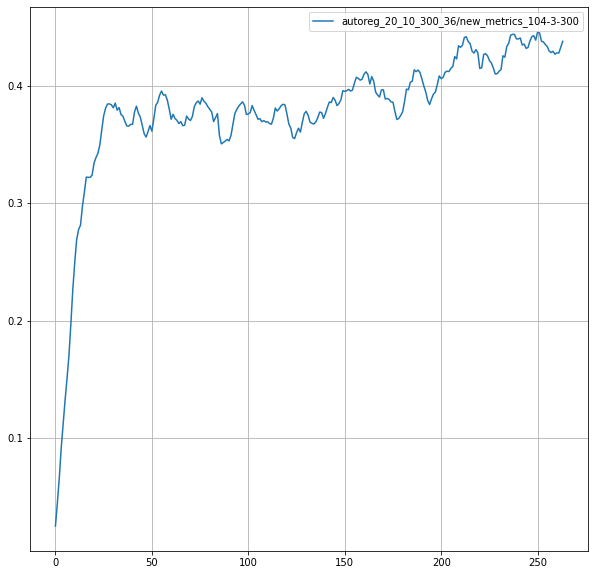

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(autoreg_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Mixed

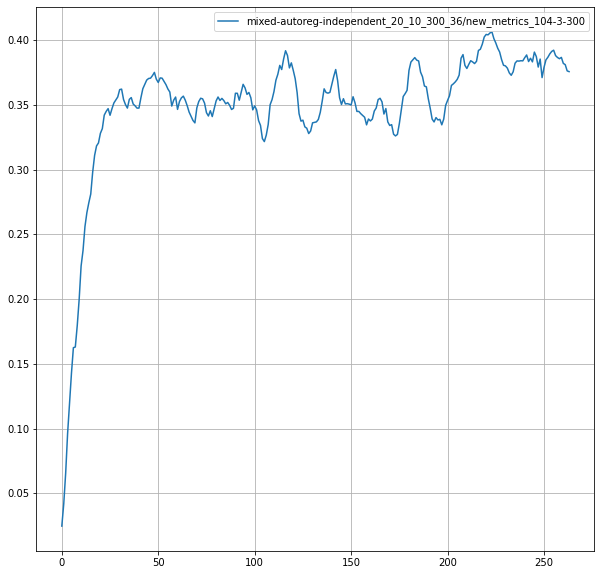

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(mixed_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Independent

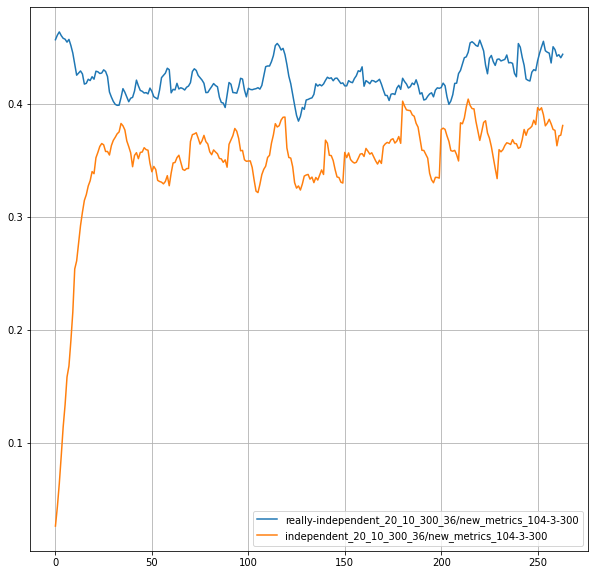

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(independent_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()